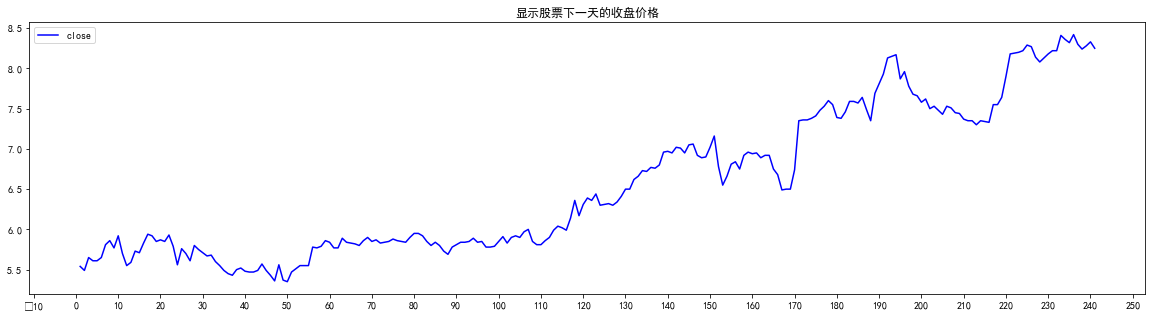

In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 生成标签值：下一天收盘价（涉及删除最后一条数据，不要重复执行该函数）
def generate_label(data_path):
   df = pd.read_csv(data_path,encoding="unicode_escape")
   next_close = list()
   for i in range(len(df['close']) - 1):     
       next_close.append(df['close'][i + 1])
   next_close.append(0)
   df['next_close'] = next_close
   df.drop(df.index[-1], inplace=True)
   df.to_csv('data1.csv', index=None)
df = pd.read_csv('data1.csv',encoding="unicode_escape")
datas =df['next_close'][1:]
plt.figure(facecolor='white',figsize=(20,5))
datas.plot(color='blue', label='close')
plt.legend(loc='best')
plt.title(U"显示股票下一天的收盘价格")
ax = plt.gca()
ax.locator_params('x',nbins=50) #调整x轴
ax.locator_params('y',nbins=10) #调整y轴
plt.show()

In [5]:


# 生成训练和测试数据
def generate_model_data(data_path,alpha,days):
    df = pd.read_csv(data_path,encoding="unicode_escape")
    train_day = int((len(df['close']) - days + 1))
    for property in ['open', 'close', 'high', 'low', 'volume','next_close']:
        df[property] = scaler.fit_transform(np.reshape(np.array(df[property]), (-1, 1)))
    X_data, Y_data = list(), list()
    # 生成时序数据
    for i in range(train_day):
        Y_data.append(df['next_close'][i+days-1])
        for j in range(days):
            for m in ['open', 'close', 'high', 'low', 'volume']:
                X_data.append(df[m][i + j])
    X_data = np.reshape(np.array(X_data),(-1,5*15))# 5表示特征数量*天数
    train_length = int(len(Y_data)* alpha)
    X_train = np.reshape(np.array(X_data[:train_length]),(len(X_data[:train_length]),days,5))
    X_test = np.reshape(np.array(X_data[train_length:]),(len(X_data[train_length:]),days,5))
    Y_train,Y_test = np.array(Y_data[:train_length]),np.array(Y_data[train_length:])
    return X_train,Y_train,X_test,Y_test

def calc_MAPE(real,predict):
    Score_MAPE = 0
    for i in range(len(predict[:, 0])):
        Score_MAPE += abs((predict[:, 0][i] - real[:, 0][i]) / real[:, 0][i])
    Score_MAPE = Score_MAPE * 100 / len(predict[:, 0])
    return Score_MAPE

def calc_AMAPE(real,predict):
    Score_AMAPE = 0
    Score_MAPE_DIV = sum(real[:, 0]) / len(real[:, 0])
    for i in range(len(predict[:, 0])):
        Score_AMAPE += abs((predict[:, 0][i] - real[:, 0][i]) / Score_MAPE_DIV)
    Score_AMAPE = Score_AMAPE * 100 / len(predict[:, 0])
    return Score_AMAPE

def evaluate(real,predict):
    RMSE = math.sqrt(mean_squared_error(real[:, 0], predict[:, 0]))
    MAE = mean_absolute_error(real[:, 0], predict[:, 0])
    MAPE = calc_MAPE(real, predict)
    AMAPE = calc_AMAPE(real, predict)
    return RMSE,MAE,MAPE,AMAPE

def lstm_model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(units=20, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='hard_sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=200, batch_size=20, verbose=1)

    trainPredict = model.predict(X_train)
    trainPredict = scaler.inverse_transform(trainPredict)
    Y_train = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))

    testPredict = model.predict(X_test)
    testPredict = scaler.inverse_transform(testPredict)
    Y_test = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))

    return Y_train, trainPredict, Y_test, testPredict

In [6]:
#data_path = 'hs300.csv'
data_path = 'data.csv'
days = 15
alpha = 0.8
generate_label(data_path)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, Y_train, X_test, Y_test = generate_model_data('data1.csv',alpha,days)
train_Y, trainPredict, test_Y, testPredict  = lstm_model(X_train, Y_train, X_test, Y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
182/182 [==============================] - 1s 3ms/step - loss: 0.0869
Epoch 2/200
182/182 [==============================] - 0s 290us/step - loss: 0.0793
Epoch 3/200
182/182 [==============================] - 0s 287us/step - loss: 0.0708
Epoch 4/200
182/182 [==============================] - 0s 314us/step - loss: 0.0607
Epoch 5/200
182/182 [==============================] - 0s 303us/step - loss: 0.0450
Epoch 6/200
182/182 [==============================] - 0s 348us/step - loss: 0.0218
Epoch 7/200
182/182 [==============================] - ETA: 0s - loss: 0.006 - 0s 352us/step - loss: 0.0067
Epoch 8/200
182/182 [==============================] - 0s 359us/step - loss: 0.0065
Epoch 9/200
182/182 [==============================] - 0s 310us/step - loss: 0.0060
Epoch 10/200
182/182 [==============================] - 0s 340us/step - loss: 0.0046
Epoch 11/200
182/

182/182 [==============================] - 0s 372us/step - loss: 0.0018
Epoch 91/200
182/182 [==============================] - 0s 363us/step - loss: 0.0022
Epoch 92/200
182/182 [==============================] - 0s 366us/step - loss: 0.0017
Epoch 93/200
182/182 [==============================] - 0s 369us/step - loss: 0.0016
Epoch 94/200
182/182 [==============================] - 0s 375us/step - loss: 0.0015
Epoch 95/200
182/182 [==============================] - 0s 328us/step - loss: 0.0014
Epoch 96/200
182/182 [==============================] - 0s 355us/step - loss: 0.0014
Epoch 97/200
182/182 [==============================] - 0s 378us/step - loss: 0.0015
Epoch 98/200
182/182 [==============================] - 0s 325us/step - loss: 0.0017
Epoch 99/200
182/182 [==============================] - 0s 349us/step - loss: 0.0015
Epoch 100/200
182/182 [==============================] - 0s 346us/step - loss: 0.0022
Epoch 101/200
182/182 [==============================] - 0s 366us/step - loss

182/182 [==============================] - 0s 330us/step - loss: 8.8017e-04
Epoch 184/200
182/182 [==============================] - 0s 312us/step - loss: 7.8515e-04
Epoch 185/200
182/182 [==============================] - 0s 331us/step - loss: 7.7720e-04
Epoch 186/200
182/182 [==============================] - 0s 308us/step - loss: 8.1041e-04
Epoch 187/200
182/182 [==============================] - 0s 302us/step - loss: 8.9672e-04
Epoch 188/200
182/182 [==============================] - 0s 289us/step - loss: 0.0010
Epoch 189/200
182/182 [==============================] - 0s 300us/step - loss: 8.1490e-04
Epoch 190/200
182/182 [==============================] - 0s 299us/step - loss: 9.7695e-04
Epoch 191/200
182/182 [==============================] - 0s 300us/step - loss: 8.0860e-04
Epoch 192/200
182/182 [==============================] - 0s 299us/step - loss: 0.0010
Epoch 193/200
182/182 [==============================] - 0s 299us/step - loss: 8.5002e-04
Epoch 194/200
182/182 [=========

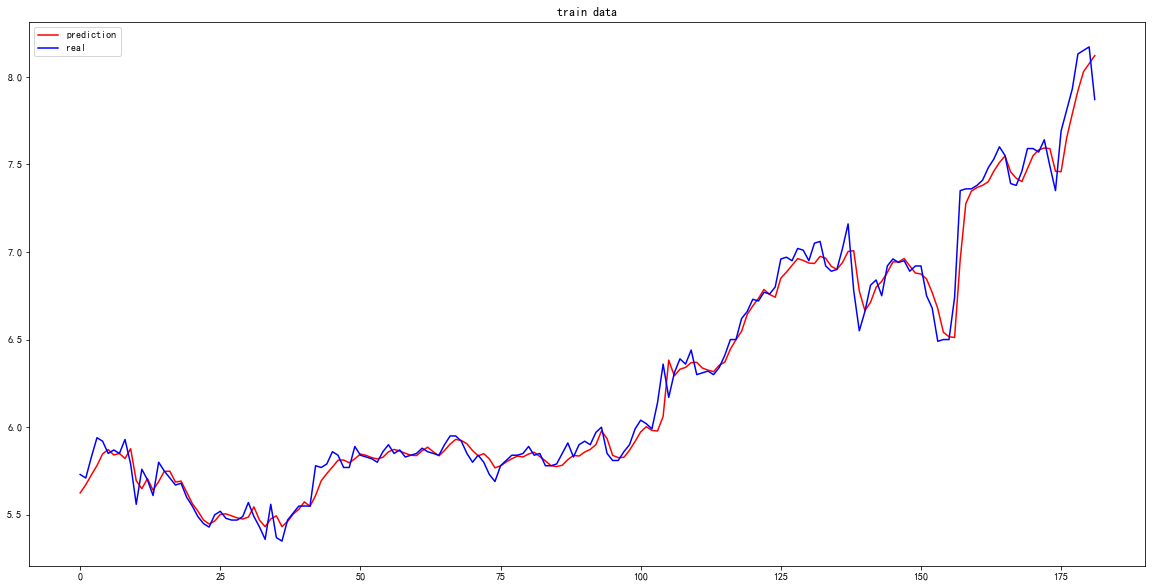

In [7]:
plt.figure(facecolor='white',figsize=(20,10))
plt.plot(list(trainPredict), color='red', label='prediction')
plt.plot(list(train_Y), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('train data')
plt.show()

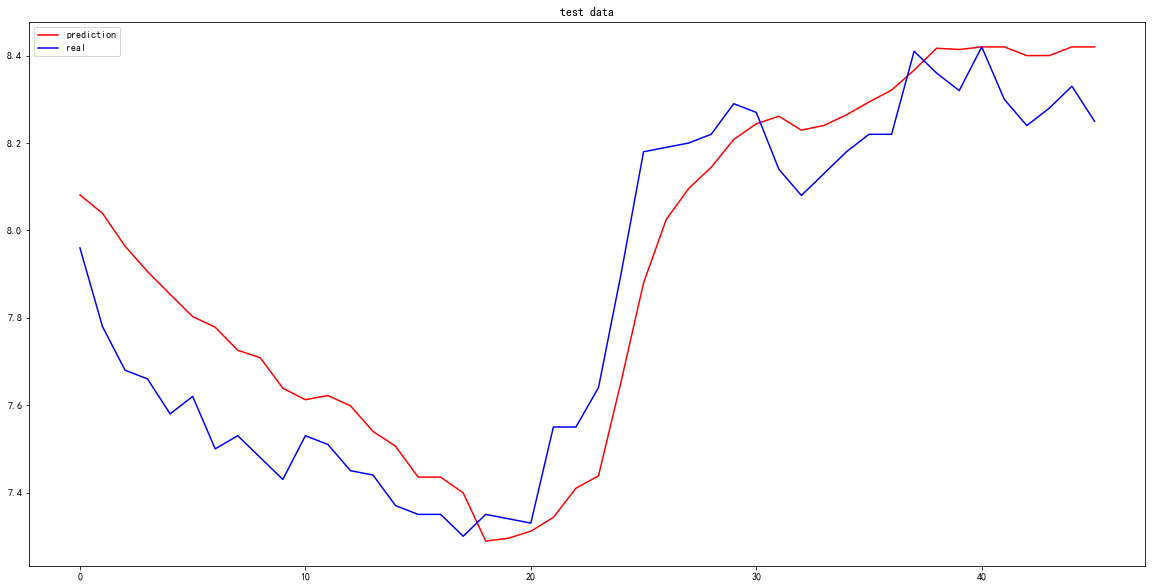

In [9]:
plt.figure(facecolor='white',figsize=(20,10))
plt.plot(list(testPredict), color='red', label='prediction')
plt.plot(list(test_Y), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('test data')
plt.show()

In [10]:
RMSE,MAE,MAPE,AMAPE = evaluate(test_Y,testPredict)
print(RMSE,MAE,MAPE,AMAPE)

0.15646572137705983 0.13684764488883633 1.7564231901892575 1.7417867975115449
